# ライブラリのインポートとデータの読み込み

In [1]:
# ライブラリの読み込み

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Loading data
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users.csv')
df_train = pd.concat([df_train['country_destination'], df_train.drop(['country_destination'], axis=1)], axis=1)
id_test = df_test['id']
piv_train = df_train.shape[0]

In [2]:
df_train.head()

,country_destination,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,NDF,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,NDF,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,US,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,other,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,US,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


# データの観察

In [3]:
df_train.shape

(213451, 16)

In [4]:
df_test.shape

(62096, 15)

## データの分布

## country_destination

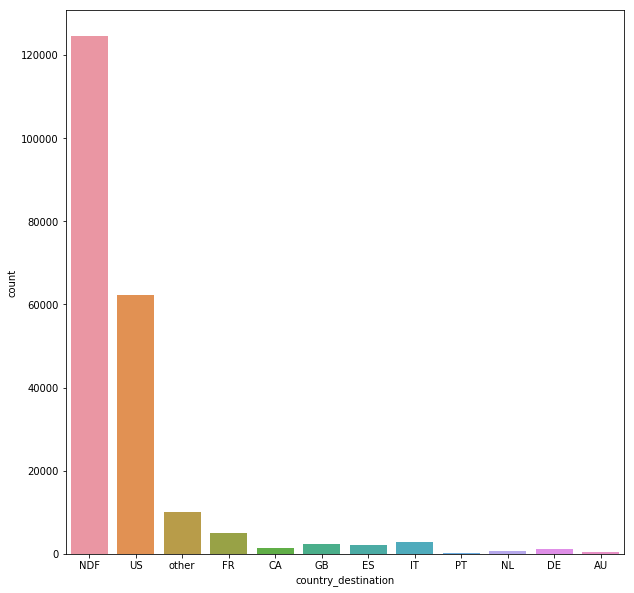

In [5]:
plt.figure(figsize = (10,10))
sns.countplot(x="country_destination", data=df_train)

## signup_method

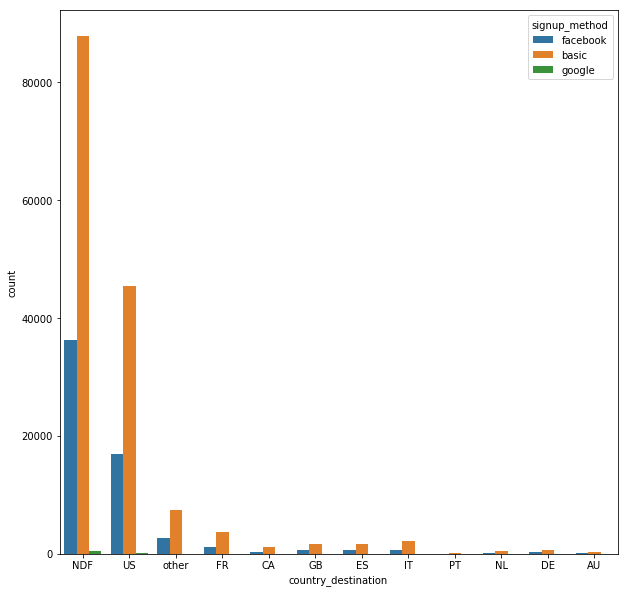

In [6]:
#country_destination * signup_method
plt.figure(figsize = (10,10))
sns.countplot(x="country_destination",hue = 'signup_method', data=df_train);

In [7]:
# 学習データとテストデータを合体
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

## Age

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


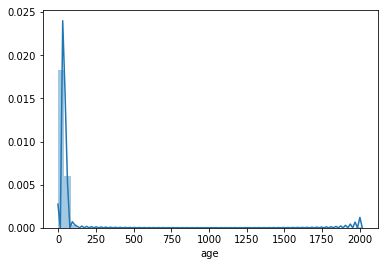

In [9]:
#age
sns.distplot(df_all['age'].dropna())

In [10]:
df_all.describe()

,age,signup_flow,timestamp_first_active
count,158681.000000,275547.000000,2.755470e+05
mean,47.145310,4.291965,2.013310e+13
std,142.629468,8.794313,9.146438e+09
min,1.000000,0.000000,2.009032e+13
25%,28.000000,0.000000,2.013040e+13
50%,33.000000,0.000000,2.014010e+13
75%,42.000000,1.000000,2.014062e+13
max,2014.000000,25.000000,2.014093e+13


In [11]:
#異常値を削除
df_all.drop(df_all[df_all['age'] > 100].index, inplace=True)
                    #df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 75)].index, inplace=True)
df_all.drop(df_all[df_all['age']<10].index, inplace=True)
                    #df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 75)].index, inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


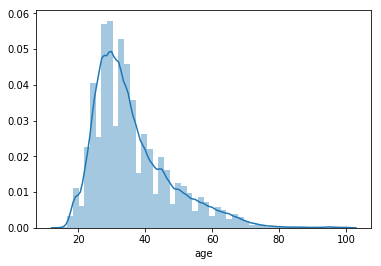

In [12]:
sns.distplot(df_all['age'].dropna())

In [13]:
#グラフ関数定義
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar',stacked=True, colormap='terrain',legend=False)

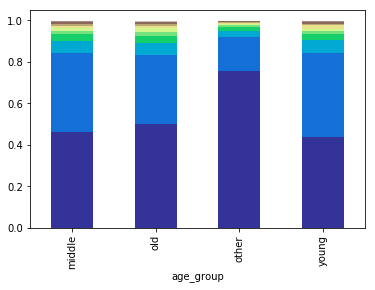

In [14]:
#age_groupの定義
def age_group(x):
    if x >=20 and x < 34:
        return 'young'
    elif x >=34 and x < 50:
        return 'middle'
    elif x >=50 and x <= 100:
        return 'old'
    else:
        return 'other'
    
df_train['age_group'] = df_train['age'].apply(age_group)
df_all['age_group'] = df_all['age'].apply(age_group)
stacked_bar('age_group')

In [15]:
#age_groupの再定義
def age_group(x):
    if x >=20 and x <= 100:
        return 'age'
    else:
        return 'other'
    
df_train['age_group'] = df_train['age'].apply(age_group)
df_all['age_group'] = df_all['age'].apply(age_group)


## signup_method

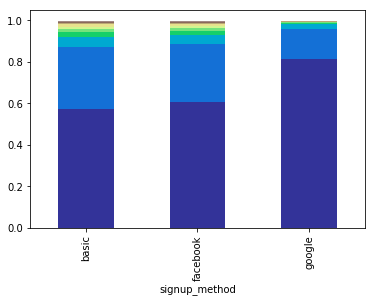

In [16]:
stacked_bar('signup_method')

## signup_flow

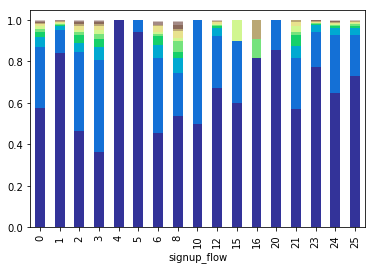

In [17]:
stacked_bar('signup_flow')

## first_device_type

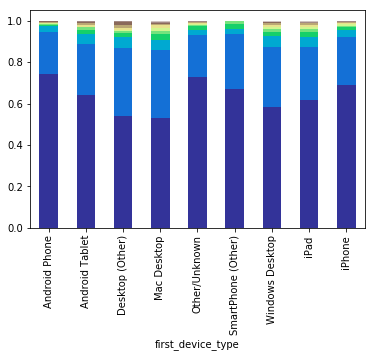

In [18]:
stacked_bar('first_device_type')

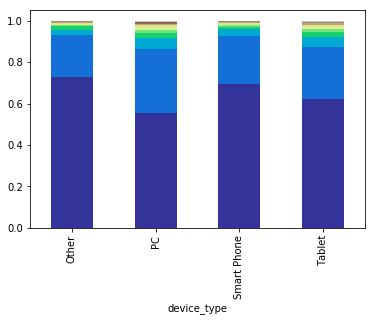

In [19]:
#デバイスタイプを再カテゴリー
def device_type(x):
    if x == 'Android Phone' or x == 'SmartPhone (Other)' or x == 'iPhone':
        return 'Smart Phone'
    elif x == 'Desktop (Other)' or x == 'Mac Desktop' or x =='Windows Desktop':
        return 'PC'
    elif x == 'Android Tablet' or x=='iPad':
        return 'Tablet'
    else:
        return 'Other'

df_train['device_type'] = df_train['first_device_type'].apply(device_type)
df_all = df_all.drop(['first_device_type'], axis=1)
stacked_bar('device_type')

## language

In [20]:
con_lang = pd.read_csv('countries.csv')
con_lang

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [21]:
df_all['language'].value_counts()

en           262852
zh             2627
fr             1492
es             1166
ko             1104
de              976
it              628
ru              503
ja              343
pt              319
sv              175
nl              133
tr               92
pl               75
da               75
no               51
cs               48
el               30
th               28
hu               24
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
Name: language, dtype: int64

In [22]:
#language 再カテゴライズ
def lang_group(x):
    if x == 'en':
        return 'en'
    elif x == 'de':
        return 'de'
    elif x == 'fr':
        return 'fr'
    elif x == 'es':
        return 'es'
    elif x == 'it':
        return 'it'
    elif x == 'nl':
        return 'nl'
    elif x == 'pt':
        return 'pt'
    else:
        return 'other'
    
df_all['lang_group'] = df_all['language'].apply(lang_group)
df_all = df_all.drop(['language'], axis=1)
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,gender,id,signup_app,signup_flow,signup_method,timestamp_first_active,age_group,lang_group
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,-unknown-,gxn3p5htnn,Web,0,facebook,20090319043255,other,en
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,MALE,820tgsjxq7,Web,0,facebook,20090523174809,age,en
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,FEMALE,4ft3gnwmtx,Web,3,basic,20090609231247,age,en
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,FEMALE,bjjt8pjhuk,Web,0,facebook,20091031060129,age,en
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,-unknown-,87mebub9p4,Web,0,basic,20091208061105,age,en


## 不要変数を削除

In [23]:
df_all = df_all.drop(['affiliate_channel','affiliate_provider','first_affiliate_tracked','first_browser','signup_app','age'], axis=1)
df_all.head()

,country_destination,date_account_created,date_first_booking,gender,id,signup_flow,signup_method,timestamp_first_active,age_group,lang_group
0,NDF,2010-06-28,NaN,-unknown-,gxn3p5htnn,0,facebook,20090319043255,other,en
1,NDF,2011-05-25,NaN,MALE,820tgsjxq7,0,facebook,20090523174809,age,en
2,US,2010-09-28,2010-08-02,FEMALE,4ft3gnwmtx,3,basic,20090609231247,age,en
3,other,2011-12-05,2012-09-08,FEMALE,bjjt8pjhuk,0,facebook,20091031060129,age,en
4,US,2010-09-14,2010-02-18,-unknown-,87mebub9p4,0,basic,20091208061105,age,en


# 欠損値の確認

In [24]:
df_all.isnull().sum()

country_destination        61749
date_account_created           0
date_first_booking        185225
gender                         0
id                             0
signup_flow                    0
signup_method                  0
timestamp_first_active         0
age_group                      0
lang_group                     0
dtype: int64

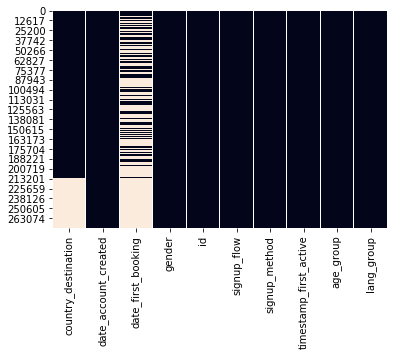

In [25]:
sns.heatmap(df_all.isnull(), cbar=False)

In [25]:
#Removing id, date_first_booking, first_affliate_tracked, first_browser, first_device_type, signup_app, signup_flow
df_all = df_all.drop(['date_first_booking'], axis=1)
df_all.head()

,country_destination,date_account_created,gender,id,signup_flow,signup_method,timestamp_first_active,age_group,lang_group
0,NDF,2010-06-28,-unknown-,gxn3p5htnn,0,facebook,20090319043255,young,en
1,NDF,2011-05-25,MALE,820tgsjxq7,0,facebook,20090523174809,middle,en
2,US,2010-09-28,FEMALE,4ft3gnwmtx,3,basic,20090609231247,old,en
3,other,2011-12-05,FEMALE,bjjt8pjhuk,0,facebook,20091031060129,middle,en
4,US,2010-09-14,-unknown-,87mebub9p4,0,basic,20091208061105,middle,en


# エンコーディング

In [26]:
# date_account_created
dac = np.vstack(
    df_all.date_account_created.astype(str).apply(
        lambda x: list(map(int, x.split('-')))
        ).values
    )
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all = df_all.drop(['date_account_created'], axis=1)

In [27]:
# timestamp_first_active
tfa = np.vstack(
    df_all.timestamp_first_active.astype(str).apply(
        lambda x: list(map(int, [x[:4], x[4:6], x[6:8],
                                 x[8:10], x[10:12],
                                 x[12:14]]))
        ).values
    )
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all = df_all.drop(['timestamp_first_active'], axis=1)

In [28]:
# One-hot-encoding features
features =  ['gender','age_group','lang_group','signup_flow','signup_method']
for f in features:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)

In [29]:
df_all.head()

,country_destination,id,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,...,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo
0,NDF,gxn3p5htnn,2010,6,28,2009,3,19,1,0,...,0,0,0,0,0,0,0,1,0,0
1,NDF,820tgsjxq7,2011,5,25,2009,5,23,0,0,...,0,0,0,0,0,0,0,1,0,0
2,US,4ft3gnwmtx,2010,9,28,2009,6,9,0,1,...,0,0,0,0,0,0,1,0,0,0
3,other,bjjt8pjhuk,2011,12,5,2009,10,31,0,1,...,0,0,0,0,0,0,0,1,0,0
4,US,87mebub9p4,2010,9,14,2009,12,8,1,0,...,0,0,0,0,0,0,1,0,0,0


# データの抽出・分割

In [30]:
# データ抽出
labels = df_train['country_destination'].values
X = df_all.iloc[:213451,:]
X_test = df_all.iloc[213451:, :]
X = X.drop(['country_destination','id'],axis=1)
X_test = X_test.drop(['country_destination'],axis=1)
#文字を数値に変換
le = LabelEncoder()
y = le.fit_transform(labels)
y = pd.DataFrame(y, columns=['country_destination'])

In [31]:
# データの分割方法を指定（層化）
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [32]:
# データの標準化
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [33]:
#X_1_train.to_csv('Xtrain.csv', header=False, index=False)
#X_1_test.to_csv('Xtest.csv', header=False, index=False)
#y_1_train.to_csv('ytrain.csv', header=False, index=False)
#y_1_test.to_csv('ytest.csv', header=False, index=False)

# 特徴量の厳選

In [34]:
# Random Forestで実施
#モデルベース選択

selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold="median")    
selector.fit(X_std, y)
mask = selector.get_support()
print(mask)

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X)
print("X_std.shape={}, X_selected.shape={}".format(X_std.shape, X_selected.shape))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


[ True  True  True  True  True  True  True  True  True False  True  True
  True  True False  True False False False False  True False  True False
 False  True False False False False False  True False False False False
 False False  True  True  True  True False False]
X_std.shape=(213451, 44), X_selected.shape=(213451, 22)


In [50]:
table = pd.DataFrame(X_std.columns, mask)
table

,0
True,dac_year
True,dac_month
True,dac_day
True,tfa_year
True,tfa_month
True,tfa_day
True,gender_-unknown-
True,gender_FEMALE
True,gender_MALE
False,gender_OTHER


# 選択した特徴量で予測・精度確認

In [37]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#インスタンス作成
clf = xgb.XGBClassifier()

# ハイパーパラメータ探索
clf_cv = GridSearchCV(clf, {'max_depth': [1,2,3], 'n_estimators': [2,5,10]}, verbose=1)
clf_cv.fit(X_selected, y)
print (clf_cv.best_params_, clf_cv.best_score_)

#最適パラメータで再度学習
clf = xgb.XGBClassifier(**clf_cv.best_params_)
clf.fit(X_selected, y)

#xgb = XGBClassifier(max_depth=5, learning_rate=0.2, n_estimators=25,objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
#xgb.fit(X_selected, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarnin

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConv

{'max_depth': 1, 'n_estimators': 5} 0.4548350675330638


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [39]:
#スコア算出
X_test_selected = selector.transform(X)

print('train accuracy: %.3f' % clf.score(X_selected, y))
print('test  accuracy: %.3f' % clf.score(X_test_selected, y))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


train accuracy: 0.583
test  accuracy: 0.583


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 予測＆提出

In [40]:
# 提出データの予測
X_test_selected = X_test.loc[:, ['dac_year','dac_month','dac_day','tfa_year','tfa_month','tfa_day','gender_-unknown-','gender_FEMALE','gender_MALE','age_group_middle','age_group_old','age_group_other','age_group_young','lang_group_en','lang_group_other','signup_flow_0','signup_flow_3','signup_flow_12','signup_flow_24','signup_flow_25','signup_method_basic','signup_method_facebook']].values
# 標準化
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test_selected)
# 提出データの予測
y_pred = clf.predict(X_test_std)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
#カントリーコードを元に戻す
y_pred_con = le.inverse_transform(y_pred)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [55]:
#idのみを抽出
X_id = X_test[['id']].values

In [56]:
#カントリーコードとidデータを結合してcsvへ
sub = pd.DataFrame(np.column_stack((X_id,y_pred_con)), columns=['id', 'country'])
sub.to_csv('sub.csv',index=False)